In [1]:
import math, random, io, warnings
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cpu'

In [2]:
EPOCHS        = 8
BATCH_SIZE    = 32
LR            = 2e-3
CLIP_NORM     = 2.0

# Vocabulary / sequence
MIN_WORD_FREQ = 1
MAX_SEQ_LEN   = 20
START_TOK     = "<start>"
END_TOK       = "<end>"
PAD_TOK       = "<pad>"
UNK_TOK       = "<unk>"

# Model sizes
EMBED_SIZE    = 128     # image embedding size from CNN
WORD_EMBED    = 128     # word embedding size
HIDDEN_SIZE   = 256     # LSTM hidden size
NUM_LAYERS    = 1

# Dataset
IMG_SIZE      = 128
NUM_SAMPLES   = 600     # total synthetic images (train+val)
TRAIN_SPLIT   = 0.9


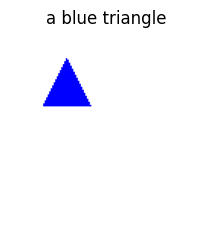

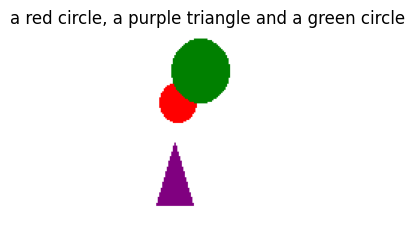

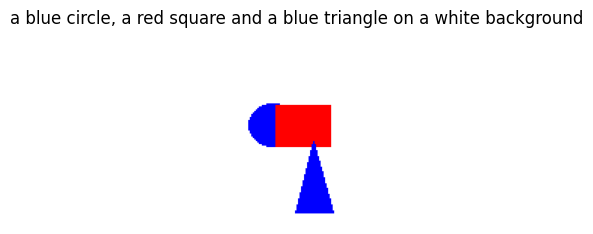

In [3]:
SHAPES  = ["square", "circle", "triangle"]
COLORS  = ["red", "green", "blue", "yellow", "purple", "orange"]
BACKS   = ["white", "gray"]  # background colors

def draw_shape(draw: ImageDraw.Draw, shape, color, bbox):
    if shape == "square":
        draw.rectangle(bbox, fill=color)
    elif shape == "circle":
        draw.ellipse(bbox, fill=color)
    elif shape == "triangle":
        x0,y0,x1,y1 = bbox
        tri = [(x0, y1), ((x0+x1)//2, y0), (x1, y1)]
        draw.polygon(tri, fill=color)

def make_scene(seed=None):
    if seed is not None:
        random.seed(seed)
    bg = random.choice(BACKS)
    img = Image.new("RGB", (IMG_SIZE, IMG_SIZE), color=bg)
    draw = ImageDraw.Draw(img)

    # choose 1–3 objects
    nobj = random.randint(1,3)
    objs = []
    for _ in range(nobj):
        shape = random.choice(SHAPES)
        color = random.choice(COLORS)
        # random bbox
        w = random.randint(24, 48)
        h = random.randint(24, 48)
        x0 = random.randint(5, IMG_SIZE-5-w)
        y0 = random.randint(5, IMG_SIZE-5-h)
        bbox = (x0, y0, x0+w, y0+h)
        draw_shape(draw, shape, color, bbox)
        objs.append((color, shape))

    # build a simple caption
    # e.g., "a red square", "a red square and a blue circle", etc.
    parts = [f"a {c} {s}" for (c,s) in objs]
    if len(parts) == 1:
        cap = parts[0]
    elif len(parts) == 2:
        cap = parts[0] + " and " + parts[1]
    else:
        cap = parts[0] + ", " + parts[1] + " and " + parts[2]

    # optional background mention
    if random.random() < 0.5:
        cap += f" on a {bg} background"
    return img, cap

# Preview a few
for _ in range(3):
    im, cp = make_scene()
    plt.figure(figsize=(2.5,2.5)); plt.imshow(im); plt.axis("off"); plt.title(cp); plt.show()


In [4]:
all_images, all_caps = [], []
for i in range(NUM_SAMPLES):
    img, cap = make_scene()
    all_images.append(img)
    all_caps.append(cap)

# Split
idx = np.arange(NUM_SAMPLES)
np.random.shuffle(idx)
cut = int(TRAIN_SPLIT * NUM_SAMPLES)
tr_idx, va_idx = idx[:cut], idx[cut:]

train_images = [all_images[i] for i in tr_idx]
train_caps   = [all_caps[i] for i in tr_idx]
val_images   = [all_images[i] for i in va_idx]
val_caps     = [all_caps[i] for i in va_idx]

len(train_images), len(val_images)


(540, 60)

In [5]:
from collections import Counter, defaultdict

def tokenize(s: str) -> List[str]:
    return s.lower().strip().replace(",", " ,").replace(".", " .").split()

SPECIAL = [PAD_TOK, UNK_TOK, START_TOK, END_TOK]
PAD_IDX, UNK_IDX, START_IDX, END_IDX = range(4)

def build_vocab(captions: List[str], min_freq=1):
    cnt = Counter()
    for c in captions:
        cnt.update(tokenize(c))
    itos = list(SPECIAL)[:]  # index -> token
    for w, f in cnt.most_common():
        if f >= min_freq and w not in SPECIAL:
            itos.append(w)
    stoi = defaultdict(lambda: UNK_IDX)
    for i, w in enumerate(itos):
        stoi[w] = i
    return dict(stoi), itos

stoi, itos = build_vocab(train_caps, MIN_WORD_FREQ)
VOCAB_SIZE = len(itos)
VOCAB_SIZE, itos[:20]


(20,
 ['<pad>',
  '<unk>',
  '<start>',
  '<end>',
  'a',
  'square',
  'triangle',
  'and',
  'circle',
  'on',
  'background',
  'blue',
  'purple',
  'yellow',
  ',',
  'orange',
  'red',
  'green',
  'white',
  'gray'])

In [6]:
def encode_caption(caption: str, max_len: int=MAX_SEQ_LEN) -> List[int]:
    toks = tokenize(caption)
    ids = [START_IDX] + [stoi.get(t, UNK_IDX) for t in toks] + [END_IDX]
    return ids[:max_len]

def decode_ids(ids: List[int]) -> str:
    words = []
    for i in ids:
        if i == END_IDX: 
            words.append(itos[i]); break
        words.append(itos[i] if i < len(itos) else UNK_TOK)
    return " ".join(words)


In [7]:
import torchvision.transforms as T
import torch

tfm_train = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

tfm_val = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

class ShapesCaptionDataset(Dataset):
    def __init__(self, images, captions, train=True):
        self.images = images
        self.caps = captions
        self.transform = tfm_train if train else tfm_val

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):
        img = self.images[i]
        cap = self.caps[i]
        x = self.transform(img)
        y = torch.tensor(encode_caption(cap), dtype=torch.long)
        return x, y, cap, img  # keep original PIL for display

def collate_pad(batch):
    # sort by caption length desc
    batch.sort(key=lambda x: len(x[1]), reverse=True)
    xs, ys, caps_txt, pil_imgs = zip(*batch)
    xs = torch.stack(xs, dim=0)

    lengths = torch.tensor([len(y) for y in ys], dtype=torch.long)
    maxlen = int(lengths.max())
    Y = torch.full((len(ys), maxlen), PAD_IDX, dtype=torch.long)
    for i, y in enumerate(ys):
        Y[i, :len(y)] = y
    return xs.to(DEVICE), Y.to(DEVICE), lengths.to(DEVICE), list(caps_txt), list(pil_imgs)

train_ds = ShapesCaptionDataset(train_images, train_caps, train=True)
val_ds   = ShapesCaptionDataset(val_images,   val_caps,   train=False)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_pad)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_pad)

len(train_ds), len(val_ds)


(540, 60)

In [8]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size=EMBED_SIZE):
        super().__init__()
        # Small convnet so it learns quickly on toy data
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=2, padding=2), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64,128, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128,256,3, stride=2, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.proj = nn.Linear(256, embed_size)
        # Use LayerNorm instead of BatchNorm to avoid batch-size=1 issues
        self.ln   = nn.LayerNorm(embed_size)

    def forward(self, x):
        f = self.features(x)          # [B,256,1,1]
        f = f.view(f.size(0), -1)     # [B,256]
        z = self.ln(self.proj(f))     # [B,embed]
        return z

class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, word_embed=WORD_EMBED, hidden_size=HIDDEN_SIZE,
                 num_layers=NUM_LAYERS, max_len=MAX_SEQ_LEN, img_embed_size=EMBED_SIZE):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, word_embed, padding_idx=PAD_IDX)
        self.lstm  = nn.LSTM(word_embed, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc    = nn.Linear(hidden_size, vocab_size)
        self.max_len = max_len

        # Map image embedding -> LSTM hidden state size (and cell state)
        self.init_h = nn.Linear(img_embed_size, hidden_size)
        self.init_c = nn.Linear(img_embed_size, hidden_size)

    def forward(self, features, captions, lengths):
        # Teacher forcing
        emb = self.embed(captions)           # [B,T,E]
        # Initialize hidden state from image features
        h0 = torch.tanh(self.init_h(features)).unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)  # [L,B,H]
        c0 = torch.tanh(self.init_c(features)).unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)  # [L,B,H]

        packed = pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=True)
        out, _ = self.lstm(packed, (h0, c0))   # out.data: [sumT, H]
        logits = self.fc(out.data)             # [sumT, V]
        return logits

    @torch.no_grad()
    def greedy_decode(self, features):
        B = features.size(0)
        h = torch.tanh(self.init_h(features)).unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)
        c = torch.tanh(self.init_c(features)).unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)

        # start with <start>
        inp = torch.full((B,1), START_IDX, dtype=torch.long, device=features.device)
        em  = self.embed(inp)
        outs = []
        for _ in range(self.max_len):
            o,(h,c) = self.lstm(em, (h,c))
            logits  = self.fc(o[:, -1, :])      # [B,V]
            nxt = logits.argmax(dim=1)          # [B]
            outs.append(nxt)
            em = self.embed(nxt.unsqueeze(1))   # next step
        return torch.stack(outs, dim=1)         # [B,T]

encoder = EncoderCNN(EMBED_SIZE).to(DEVICE)
decoder = DecoderRNN(VOCAB_SIZE, img_embed_size=EMBED_SIZE).to(DEVICE)

# Print a compact encoder "summary" by passing a dummy tensor
dummy = torch.zeros(1,3,IMG_SIZE,IMG_SIZE).to(DEVICE)
with torch.no_grad():
    z = encoder(dummy)
print("Encoder output shape:", tuple(z.shape))

enc_params = sum(p.numel() for p in encoder.parameters())
dec_params = sum(p.numel() for p in decoder.parameters())
print(f"Total Encoder Params: {enc_params:,}")
print(f"Total Decoder Params: {dec_params:,}")
print(f"Total Model Params:   {enc_params + dec_params:,}")


Encoder output shape: (1, 128)
Total Encoder Params: 423,104
Total Decoder Params: 469,012
Total Model Params:   892,116


In [9]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=LR)

def show_img_with_title(pil_img: Image.Image, title: str):
    plt.figure(figsize=(2.8,2.8))
    plt.imshow(pil_img); plt.axis("off")
    plt.title(title)
    plt.show()

def batch_step(batch, train=True):
    encoder.train(mode=train); decoder.train(mode=train)
    xs, Y, lengths, caps_txt, pil_imgs = batch
    # Targets are captions shifted right (predict token t given tokens up to t-1).
    # A common trick: we feed the whole caption and predict each position.
    # Because we used packed sequence, our logits align with the packed targets (Y).
    logits = decoder(encoder(xs), Y, lengths)          # [sumT, V]
    targets = pack_padded_sequence(Y, lengths.cpu(), batch_first=True, enforce_sorted=True).data  # [sumT]
    loss = criterion(logits, targets)
    if train:
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(encoder.parameters())+list(decoder.parameters()), CLIP_NORM)
        optimizer.step()
    return loss.item(), pil_imgs[0], caps_txt[0]


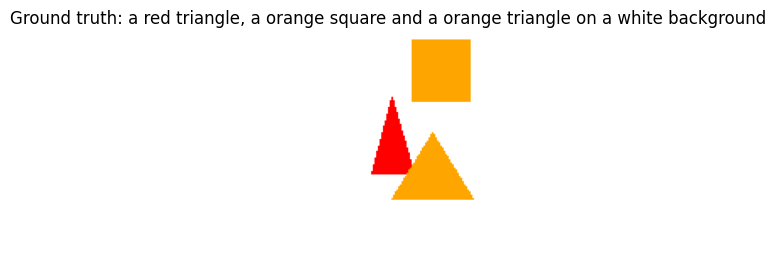

[Epoch 01] Train Loss: 1.2812 | Val Loss: 0.0972


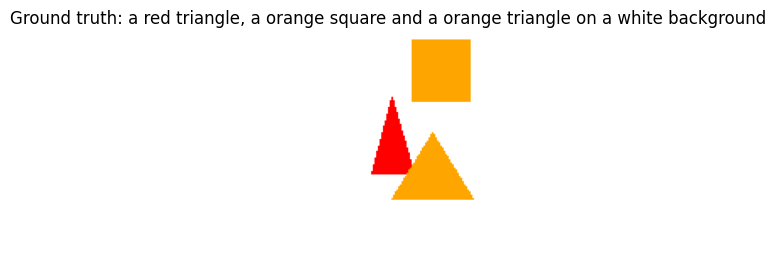

[Epoch 02] Train Loss: 0.0246 | Val Loss: 0.0044


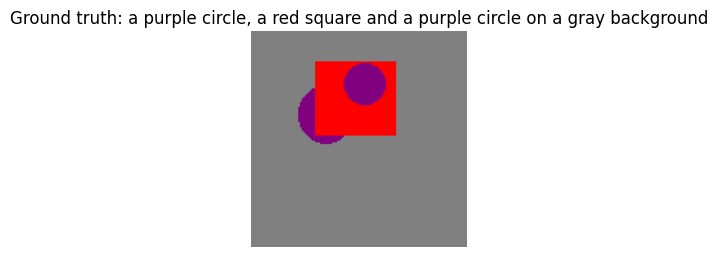

[Epoch 03] Train Loss: 0.0027 | Val Loss: 0.0018


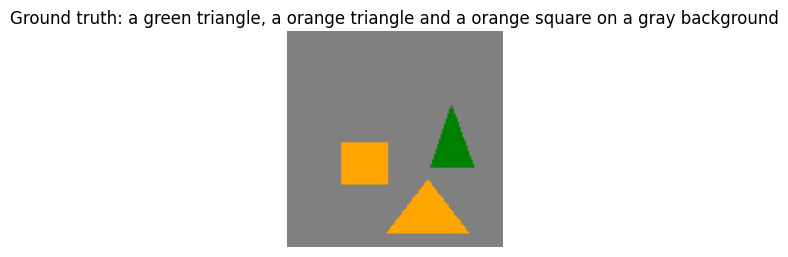

[Epoch 04] Train Loss: 0.0014 | Val Loss: 0.0012


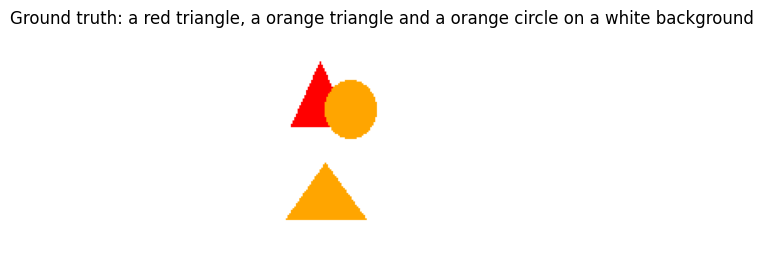

[Epoch 05] Train Loss: 0.0011 | Val Loss: 0.0010


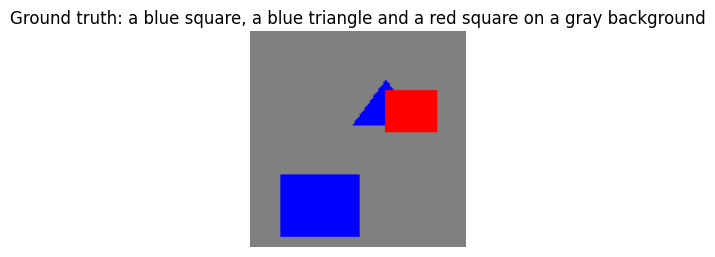

[Epoch 06] Train Loss: 0.0009 | Val Loss: 0.0009


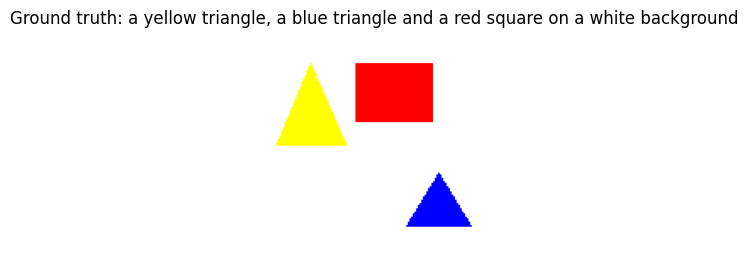

[Epoch 07] Train Loss: 0.0008 | Val Loss: 0.0008


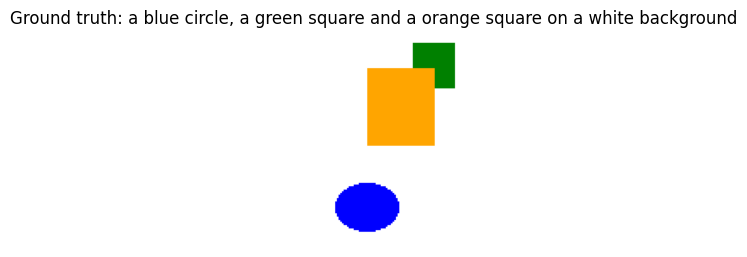

[Epoch 08] Train Loss: 0.0007 | Val Loss: 0.0007


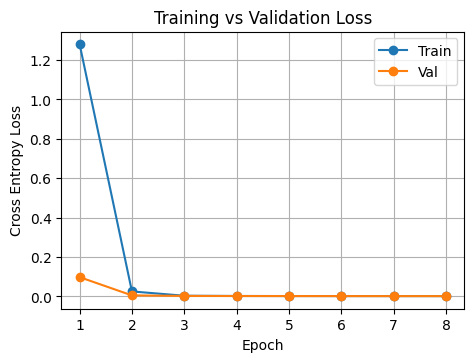

In [10]:
train_losses, val_losses, epochs_x = [], [], []

for epoch in range(1, EPOCHS+1):
    # ---- Train ----
    trn = []
    shown = False
    for batch in train_dl:
        loss, pil0, cap0 = batch_step(batch, train=True)
        trn.append(loss)
        if not shown:
            show_img_with_title(pil0, f"Ground truth: {cap0}")
            shown = True
    trn_loss = float(np.mean(trn)) if trn else float("nan")

    # ---- Val ----
    val = []
    encoder.eval(); decoder.eval()
    with torch.no_grad():
        for batch in val_dl:
            loss, pil0, cap0 = batch_step(batch, train=False)
            val.append(loss)
    val_loss = float(np.mean(val)) if val else float("nan")

    train_losses.append(trn_loss); val_losses.append(val_loss); epochs_x.append(epoch)
    print(f"[Epoch {epoch:02d}] Train Loss: {trn_loss:.4f} | Val Loss: {val_loss:.4f}")

# Plot train vs val loss
plt.figure(figsize=(5.2,3.6))
plt.plot(epochs_x, train_losses, marker="o", label="Train")
plt.plot(epochs_x, val_losses,   marker="o", label="Val")
plt.xlabel("Epoch"); plt.ylabel("Cross Entropy Loss")
plt.title("Training vs Validation Loss")
plt.grid(True); plt.legend(); plt.show()


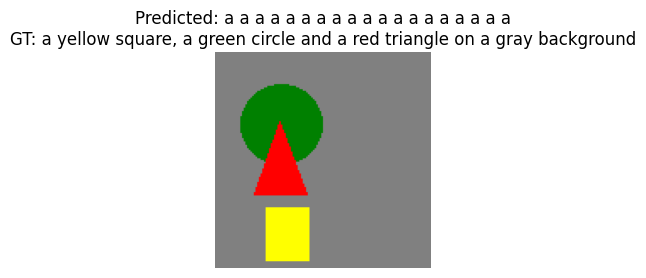

In [11]:
encoder.eval(); decoder.eval()
if len(val_ds) > 0:
    i = random.randrange(len(val_ds))
    x, y, gt_text, pil_img = val_ds[i]
    with torch.no_grad():
        feat = encoder(x.unsqueeze(0).to(DEVICE))
        pred = decoder.greedy_decode(feat)[0].tolist()
    # Convert to words; stop at <end>
    words = []
    for idx in pred:
        tok = itos[idx] if 0 <= idx < len(itos) else UNK_TOK
        if tok == END_TOK: break
        if tok != PAD_TOK and tok != START_TOK:
            words.append(tok)
    hyp = " ".join(words) if words else "(empty)"
    show_img_with_title(pil_img, f"Predicted: {hyp}\nGT: {gt_text}")
else:
    print("No validation samples available.")


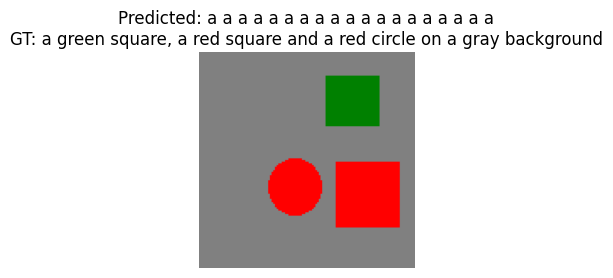

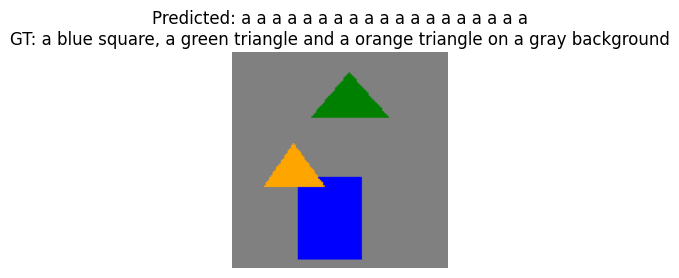

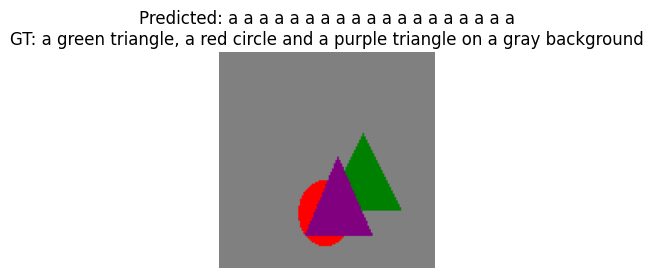

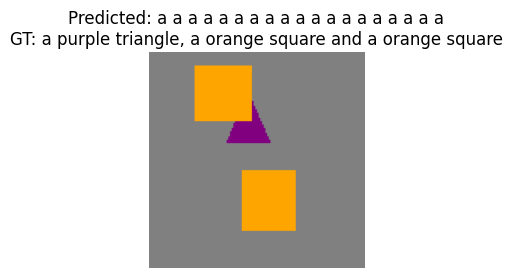

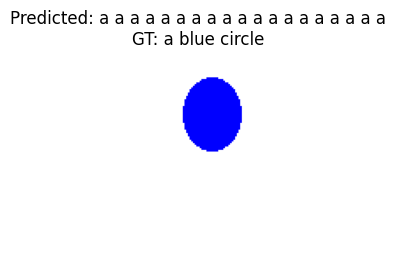

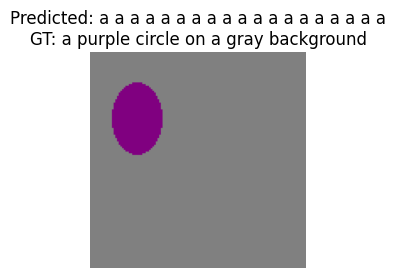

In [12]:
N = min(6, len(val_ds))
inds = random.sample(range(len(val_ds)), k=N) if len(val_ds) >= N else list(range(len(val_ds)))
encoder.eval(); decoder.eval()
for i in inds:
    x, _, gt_text, pil_img = val_ds[i]
    with torch.no_grad():
        feat = encoder(x.unsqueeze(0).to(DEVICE))
        pred = decoder.greedy_decode(feat)[0].tolist()
    words = []
    for idx in pred:
        tok = itos[idx] if 0 <= idx < len(itos) else UNK_TOK
        if tok == END_TOK: break
        if tok not in (PAD_TOK, START_TOK):
            words.append(tok)
    hyp = " ".join(words) if words else "(empty)"
    show_img_with_title(pil_img, f"Predicted: {hyp}\nGT: {gt_text}")
